# INSTAGRAM: DETECCIÓN DE USUARIOS FALSOS

## **Entrenamiento y evaluación de modelos**

<img src="https://miracomohacerlo.com/wp-content/uploads/2019/02/como-ver-a-que-fotos-le-da-like-en-instagram-una-persona-2.jpg" />

In [13]:
%matplotlib inline

In [14]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

## **DATASET**

In [15]:
dataset_original = pd.read_csv('instagram.csv')
dataset = dataset_original

renamed_columns = {'pos':'post','flw':'followers','flg':'following','bl':'biography_lenght','pic':'profile_picture','lin':'external_url','cl':'post_lenght','cz':'post_lenght_null','ni':'none_image','erl':'engagement_rate_likes','erc':'engagement_rate_comments','lt':'post_location','hc':'hashtags_post','pr':'hashtags_promotional','fo':'hashtags_followers','cs':'cosine_similarity','pi':'interval_post','class':'user_class'}
dataset.rename(columns = renamed_columns, inplace = True)

dataset["user_class"] = dataset.user_class.replace(['f','r'], [1, 0])

### **Train, Validation, Test**

In [16]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

## **MÉTRICAS**

Al inicio elegimos la métrica **Precision** ya que al momento de predecir queríamos estar seguros de que una cuenta falsa realmente lo era. Sin embargo, precision no nos da la información completa, por lo que también teniamos que tener en cuenta **Recall** que nos permite saber del total de cuentas falsas cuantas encontró.
Por lo tanto, la métrica elegida es **F1-Score** que combina **Precision** y **Recall** y nos permite saber la información completa ya que si una de las dos métrica empeora, la otra mejora.

## FEATURE ENGINEERING

No nos pareció útil usar técnicas de Feature Engineering ya que los datos eran representativos. Por ejemplo, no tenemos información escondida en columnas, la mayoría de los valores son binarias, representan porcentajes o cantidades. Tampoco tenemos que redondear valores o convertirlos a rangos fijos ya que nuestras variables numéricas son porcentajes o enteros.
Sin embargo, si utilizamos técnicas de **pre-procesamiento** como por ejemplo estandarización.

### **MAPPER**

In [17]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [18]:
mapper = DataFrameMapper([
    (['post'], [StandardScaler()]),
    (['followers'], [StandardScaler()]),
    (['following'], [StandardScaler()]),
    (['biography_lenght'], [StandardScaler()]),
    (['profile_picture'], None),
    (['external_url'], None),
    (['post_lenght'], [StandardScaler()]),
    (['post_lenght_null'], None),
    (['none_image'], None),
    (['engagement_rate_likes'], [StandardScaler()]),
    (['engagement_rate_comments'], [StandardScaler()]),
    (['post_location'], None),
    (['hashtags_post'], [StandardScaler()]),
    (['hashtags_promotional'], [StandardScaler()]),
    (['hashtags_followers'], [StandardScaler()]),
    (['cosine_similarity'], None),
    (['interval_post'], [StandardScaler()])
])

mapper.fit(train)
mapper.transform(train)

array([[-0.21210962,  0.10204398, -0.55635834, ..., -0.09576444,
         0.199697  ,  1.20202857],
       [ 1.62952357, -0.01657636,  0.64975109, ..., -0.09576444,
         0.36353901, -0.51571389],
       [ 0.04868542, -0.01341731, -0.68557057, ..., -0.09576444,
         0.019077  , -0.21574997],
       ...,
       [-0.20222166, -0.04144837,  0.95831762, ..., -0.09576444,
         0.204803  , -0.45033775],
       [-0.20592964, -0.05145947, -0.84718229, ..., -0.09576444,
         0.22060999, -0.47027995],
       [ 0.46768787,  0.23552525,  1.45973824, ..., -0.09576444,
         0.17518701, -0.3990643 ]])

In [19]:
mapper.transformed_names_

['post',
 'followers',
 'following',
 'biography_lenght',
 'profile_picture',
 'external_url',
 'post_lenght',
 'post_lenght_null',
 'none_image',
 'engagement_rate_likes',
 'engagement_rate_comments',
 'post_location',
 'hashtags_post',
 'hashtags_promotional',
 'hashtags_followers',
 'cosine_similarity',
 'interval_post']

## **MODELOS**

### **Función para evaluar modelos**

In [20]:
from sklearn import metrics

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [21]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.user_class
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['real', 'fake'])
            ax.yaxis.set_ticklabels(['real', 'fake'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')
        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### **REGRESIÓN LOGÍSTICA**

In [22]:
from sklearn.linear_model import LogisticRegression

,Accuracy,Precision,Recall,F1
train,0.810690,0.822007,0.796606,0.809107
validation,0.809721,0.821922,0.794716,0.808090


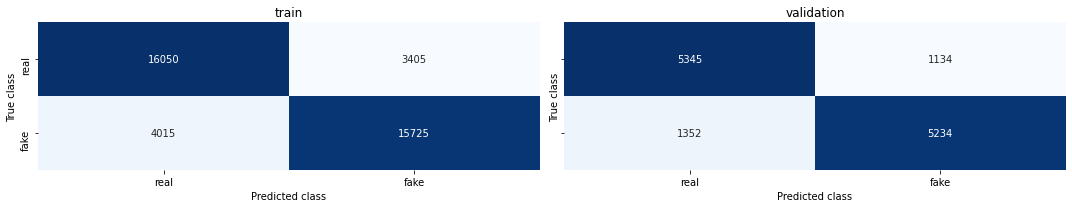

In [23]:
model_lr = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

model_lr.fit(train, train.user_class)

evaluate_model(model_lr)

#### Importancias de variables

<AxesSubplot:xlabel='coeficiente', ylabel='feature'>

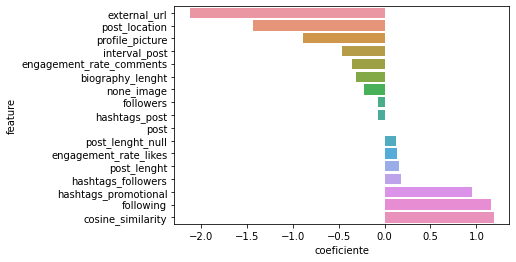

In [24]:
clf = model_lr.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

df_importance = pd.DataFrame({
    'feature': mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

**Conclusiones:**
- Cuanto mas cantidad de following tenga un cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas cantidad de uso de hashtags promocionales tenga una cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas porcentaje de publicaciones con ubicación tenga una cuenta, mas probabilidades tiene de ser real. 
- Si la variable external_URL es 0, mas probabilidades hay de que la cuenta sea falsa. En cambio si es 1 de que sea real.


### **K NEAREST NEIGHBORS**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.853782,0.909548,0.788045,0.844448
validation,0.830922,0.888376,0.760097,0.819246


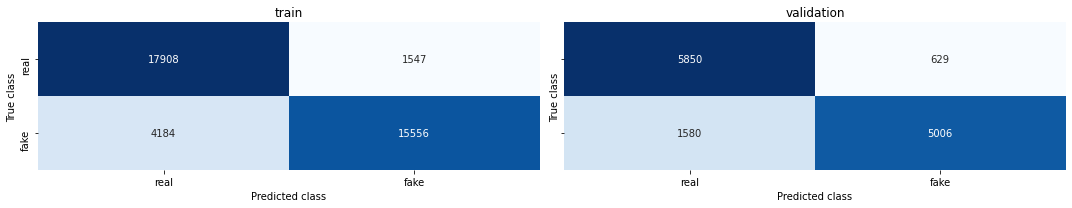

In [26]:
K = 10

model_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

model_knn.fit(train, train.user_class)

evaluate_model(model_knn, title='Knn')

### **ÁRBOLES DE DECISIÓN**

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,1.000000,1.00000,1.000000,1.000000
validation,0.853502,0.84991,0.861524,0.855678


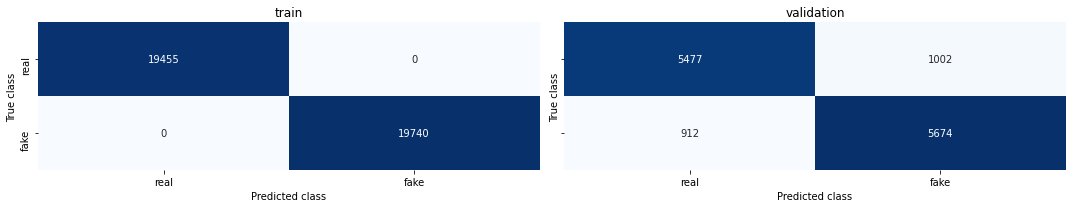

In [28]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

Tal como observamos en la matriz de confusión **en train el algoritmo acertó todos los casos**, es decir, no tuvo fallas (la cantidad de casos que dijo que eran falsos y en realidad eran verdaderos es 0). Sin embargo en validation observamos que si tuvo fallas a la hora de predecir por lo que entendemos que en train está haciendo **overfiting.** 

Por lo cual agregamos un valor de máxima profundidad: 

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.905345,0.962867,0.844630,0.899881
validation,0.886720,0.942614,0.825539,0.880201


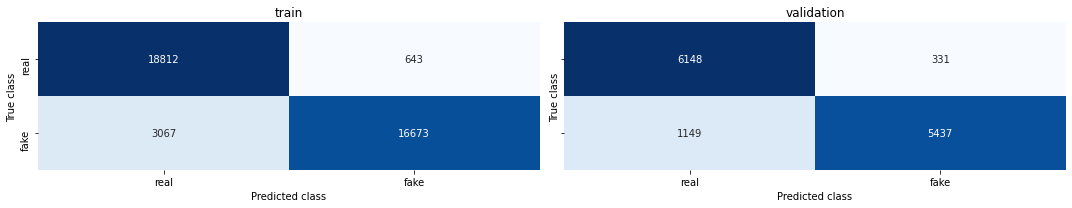

In [29]:
model_tree_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = 10, random_state=42)),
])

model_tree_maxdepth.fit(train, train.user_class)

evaluate_model(model_tree_maxdepth, title='Decision Tree')

### **RANDOM FOREST**

In [30]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.900957,0.955108,0.843152,0.895645


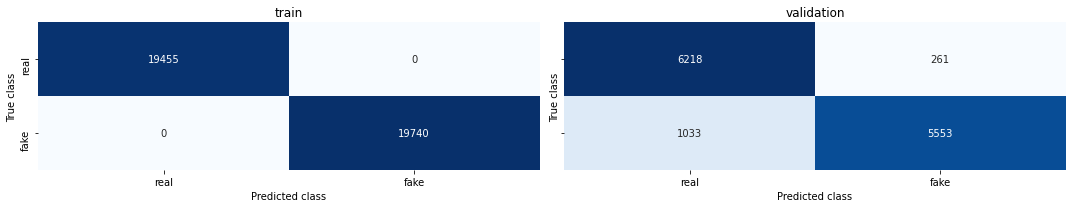

In [31]:
forest_model = RandomForestClassifier(random_state=42)

model_rf = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

model_rf.fit(train, train.user_class)

evaluate_model(model_rf, title='Random Forest')

Observamos que al no indicar un límite de profundidad y cantidad de estimadores obtenemos una precisión de 1, por lo que entendemos que el algorítmo **está sobreentrenando.** 
A su vez observamos en la matriz de confusión que en train la cantidad de predicciones falsas que en realidad eran reales es 0 y en validation la cantidad de predicciones falsas que en realidad eran reales es 1049.

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.910193,0.989321,0.830648,0.903068
validation,0.895905,0.974746,0.814607,0.887510


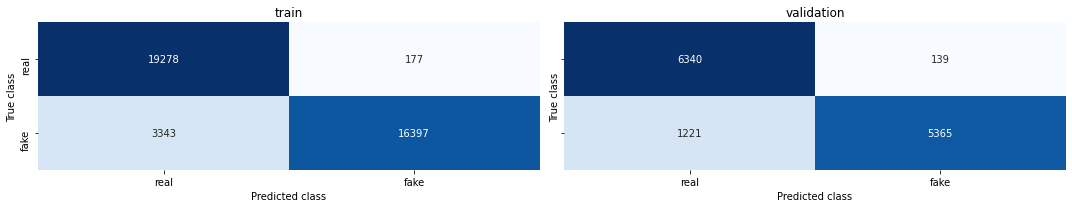

In [32]:
forest_model_maxdepth = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=5, random_state=42)

model_rf_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth),
])

model_rf_maxdepth.fit(train, train.user_class)

evaluate_model(model_rf_maxdepth, title='Random Forest')


### **GRADIENT BOOSTED TREES**

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.900421,0.956635,0.840375,0.894744
validation,0.899732,0.955771,0.839964,0.894133


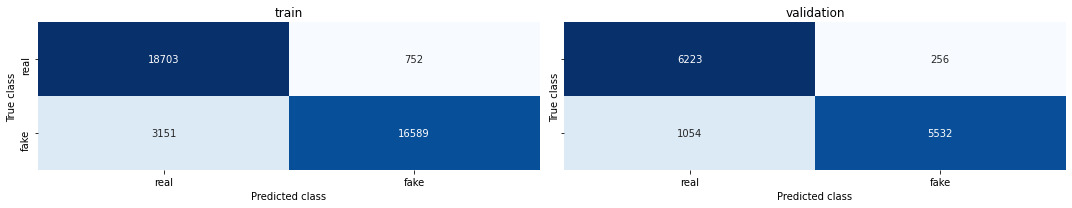

In [34]:
boost_model = GradientBoostingClassifier(random_state=42)

model_gradient_boosted = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

model_gradient_boosted.fit(train, train.user_class)

evaluate_model(model_gradient_boosted, title='Gradient Boosting')

### EVITANDO OVERFITING

En primer lugar, dividimos el dataset en **Train, Validation y Test** y para identificar si un algoritmo estaba sobreentrenando con la ayuda de la **matriz de confusión** observabamos los valores resultantes e identificabamos las diferencias entre Train y Validation como por ejemplo en árboles de decisión sin profundidad, donde en los casos de Train los valores de fallas eran 0 y eso nos indicaban que existía overfitting. Al mismo tiempo, en la evaluación de estos algoritmos obteniamos una precisión del 100% en todas las métricas, lo que también nos indicaba que los algortimos estaban sobreentrenando.

Para evitar el overfitting en estos casos indicamos: 
- Cantidad de vecinos en KNN
- Límite de profundidad en Arboles de Decision 
- Límite de profundidad en Random Forest

Ahora bien para saber cuál debería ser la cantidad de vecinos o máxima profundidad mas apropiada para indicarle a los modelos, graficamos las **curvas de aprendizaje** y a partir de ello seleccionamos el valor mas eficiente.


#### Curva para KNN

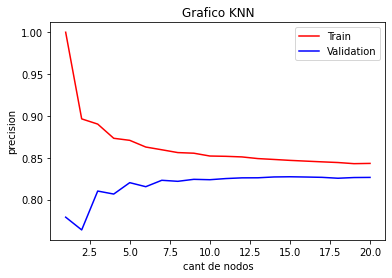

In [24]:
train_prec =  []
eval_prec = []
max_k = list(range(1, 21))

for k in max_k:
    
    model_knn_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=k)),
    ])
    
    knn=model_knn_curva    
    knn=knn.fit(train, train.user_class)    
    train_prec.append(knn.score(train, train.user_class))
    # print(knn.score(train, train.user_class))
    eval_prec.append(knn.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_k, train_prec, color='r', label='Train')
plt.plot(max_k, eval_prec, color='b', label='Validation')
plt.title('Grafico KNN')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cantidad de vecinos')
plt.show()

El valor de k mas eficiente se debe encontrar entre 5 y 10. A partir de 10 la curva de aprendizaje se estanca y el algoritmo deja de aprender.

#### Curva para Arboles de decisión 

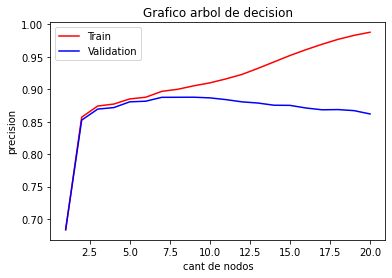

In [26]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))

for deep in max_deep_list:
    
    model_tree_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = deep, random_state=42)),
    ])
     
    arbol_tree=model_tree_maxdepth_curva    
    arbol_tree=arbol_tree.fit(train, train.user_class)    
    train_prec.append(arbol_tree.score(train, train.user_class))
    #print(arbol_tree.score(train, train.user_class))
    eval_prec.append(arbol_tree.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('nivel de profundidad')
plt.show()

En el gráfico observamos que entre los valores 5 y 7,5 las curvas se van separando, y a su vez a partir de 10 la curva de validation comienza a caer por lo que a partir de ese momento podemos inferir que el modelo esta sobreentrenando, ya que en los casos nuevos no está acertado las predicciones. Lo que ocurre es que mientras en train va acertando cada vez mas la predicciones en validation va errando.

#### Curva para Random forest

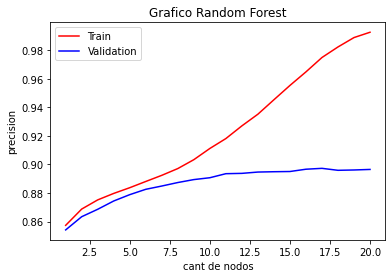

In [27]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))

for deep in max_deep_list:
    
    forest_model_maxdepth_curva = RandomForestClassifier(n_estimators=100, max_depth=deep, max_features=5, random_state=42)

    model_rf_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth_curva),
    ])
    
    arbol_rf=model_rf_maxdepth_curva    
    arbol_rf=arbol_rf.fit(train, train.user_class)    
    train_prec.append(arbol_rf.score(train, train.user_class))
    #print(arbol_rf.score(train, train.user_class))
    eval_prec.append(arbol_rf.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico Random Forest')
plt.legend()
plt.ylabel('precision')
plt.xlabel('nivel de profundidad')
plt.show()

A medida que avanzan las iteraciones, observamos que la métrica en validation no mejora. A partir del valor 10 aproximadamente la curva se estanca.

### EVALUACIÓN FINAL DE MODELOS - VALOR FINAL DE LA MÉTRICA

In [35]:
evaluate_model(model_lr, title='Regresión Logística', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_knn, title='KNN', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_tree_maxdepth, title='Arbol de decisión', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_rf_maxdepth, title='Random Forest', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_gradient_boosted, title='Gradient Boosting', set_names=('train', 'validation','test'), show_cm=False)

'Regresión Logística'

,Accuracy,Precision,Recall,F1
train,0.810690,0.822007,0.796606,0.809107
validation,0.809721,0.821922,0.794716,0.808090
test,0.812261,0.823083,0.796024,0.809328


'KNN'

,Accuracy,Precision,Recall,F1
train,0.853782,0.909548,0.788045,0.844448
validation,0.830922,0.888376,0.760097,0.819246
test,0.837747,0.893238,0.767584,0.825658


'Arbol de decisión'

,Accuracy,Precision,Recall,F1
train,0.905345,0.962867,0.844630,0.899881
validation,0.886720,0.942614,0.825539,0.880201
test,0.886040,0.938227,0.826758,0.878973


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.910193,0.989321,0.830648,0.903068
validation,0.895905,0.974746,0.814607,0.887510
test,0.897291,0.973579,0.816972,0.888427


'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.900421,0.956635,0.840375,0.894744
validation,0.899732,0.955771,0.839964,0.894133
test,0.896908,0.951330,0.836850,0.890425


**Modelo elegido: Gradient Boosting**

**Precision de F1: 89%**

### Conclusión final

Comparando los resultados de todos los modelos, concluimos que **Arboles de decision, Random Forest y Gradient Boosting poseen resultados muy parecidos**, el mejor valor de la métrica F1 es el que devuelve **Gradient Boosting con 89%** por lo que es el modelo elegido.

La métrica a informar al cliente es 89 %, por lo que el modelo va a acertar un 89 % de las veces cuando prediga que una cuenta es falsa.